# Dog Breed Classifier
## Deep Learning (Supervised): Computer Vision, Classification
## Python, TensorFlow, Keras, Convolutional Neural Network (CNN)

---
### Description

This project will develop an algorithm that could be used as part of a mobile or web app as a dog breed classifier. The code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN model that infers dog breed. There are many points of possible failure, and no perfect algorithm exists.  

### This algorithm accepts a file path to an image and first determines...
 - **If the image contains a human, dog, or neither, then...**
   - **if a dog is detected in the image, returns the predicted breed.**
   - **if a human is detected in the image, returns the resembling dog breed.**
   - **if neither is detected in the image, provides output that indicates an error.**

## Table of Contents

* [Step 0](#step0): **Import Datasets** 


* [Step 1](#step1): **Create Human Face Detector -- Using Haar Cascades (OpenCV)** 
* [Step 2](#step2): **Create Dog Detector -- Using ResNet-50 (Deep Residual Learning)**


* [Step 3](#step3): **Dog Breed Classifer -- Method 1: Creating and Training CNN from Scratch**
* [Step 4](#step4): **Dog Breed Classifer -- Method 2: Using Transfer Learning (VGG-16)**
* [Step 5](#step5): **Dog Breed Classifer -- Method 3: Using Transfer Learning (Inception)**


* [Step 6](#step6): **Write your Algorithm -- Dog Detector and Breed Classifier**
* [Step 7](#step7): **Test Your Algorithm -- Dog Detector and Breed Classifier**

### Dataset
- [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) -- unzip to ./dogImages
- [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip): -- unzip to ./lfw

###  Bottleneck Features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) -- unzip to ./bottleneck_features
- [VGG-16](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz) -- unzip to ./bottleneck_features 
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) -- unzip to ./bottleneck_features 
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) -- unzip to ./bottleneck_features 
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) -- unzip to ./bottleneck_features 

### References

- [OpenCV: Face Detection using Haar Cascades](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
- [OpenCV: Pre-trained Face Detectors](https://github.com/opencv/opencv/tree/master/data/haarcascades)


- [ResNet-50: Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
- [ImageNet: 14M images in 1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 


- [VGG-16: Very Deep Convolutional Networks for Large-Scale Visual Recognition](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)


- [Improved Bottleneck Features Using Pretrained Deep Neural Networks](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Bottleneck-Interspeech2011-pub.pdf)

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog and Human Datasets
- [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) -- unzip to ./dogImages
- [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip): -- unzip to ./lfw

In [2]:
import pandas as pd

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
            
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  

from keras.utils import np_utils
from sklearn.datasets import load_files     
import numpy as np
from glob import glob
import random
from tqdm import tqdm
from keras.preprocessing import image   

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Lambda
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

import sys
print(sys.version)

#from tensorflow.python.client import device_lib
#print (device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)

3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]


- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels
- `human_files`- numpy array that stores file paths for a dataset of human images

In [3]:
%%time

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

random.seed(8675309)
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

human_files_short = human_files[:100] # do not modify
dog_files_short = train_files[:100] # do not modify

print('\n\nThere are %d total human images.' % len(human_files),'\n')

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


There are 13233 total human images. 

Wall time: 1.87 s


---
<a id='step1'></a>
## Step 1: Create Face Detector -- Using Haar Cascades (OpenCV)
- [OpenCV: Face Detection using Haar Cascadesl](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
- [OpenCV: Pre-trained Face Detectors](https://github.com/opencv/opencv/tree/master/data/haarcascades)


- `faces` is a numpy array of detected faces, where each row corresponds to a detected face. 
- Each detected face in `faces` is a 1D array with four entries (`x`, `y`, `w`, `h`) that specifies the bounding box of the detected face.
- `x` and `y` specify the horizontal and vertical positions of the top left corner of the bounding box. 
- `w` and `h` specify the width and height of the box.

In [4]:
def find_faces(image):
    img = cv2.imread(image) # load color (BGR) image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert BGR image to grayscale
    faces = face_cascade.detectMultiScale(gray) # find faces in image
    return faces, img

def show_face_image(faces, img):
    print('Number of Human Faces detected:', len(faces))
    for (x,y,w,h) in faces: # get bounding box for each detected face
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # add bounding box to color image
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR image to RGB for plotting
    plt.imshow(cv_rgb) # display the image, along with bounding box
    plt.show()

haar_file = 'haarcascades/haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier(haar_file)
print ('Haar Cascade Algorithm:', haar_file)

Haar Cascade Algorithm: haarcascades/haarcascade_frontalface_alt.xml


Number of Human Faces detected: 1


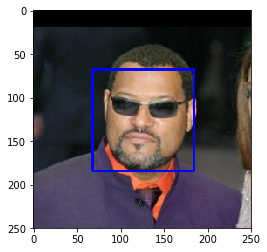

Wall time: 1.21 s


In [5]:
%%time

faces, img = find_faces(human_files[3])
show_face_image(faces, img) 

Number of Human Faces detected: 4


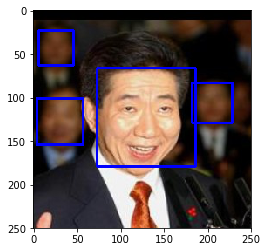

In [6]:
def find_max_number_of_faces():
    max_faces = [0,0,0,0]
    for k in range(200): 
        faces, img = find_faces(human_files[k])
        if len(faces) > max_faces[0]: max_faces = [len(faces), k, faces, img]
    show_face_image(max_faces[2], max_faces[3])  
    
find_max_number_of_faces()

Number of Human Faces detected: 1


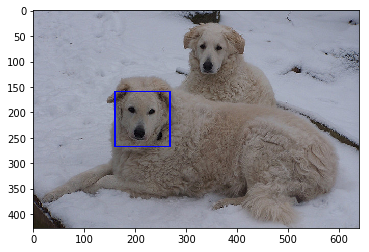

In [7]:
def find_false_positive_human_face():
    for k in range(100):
        faces, img = find_faces(train_files[k])
        if len(faces) == 1: break
    show_face_image(faces, img)   
    
find_false_positive_human_face()

### Face Detector : Performance of the Algorithm

In [8]:
%%time

def face_detector(img_path, face_cascade): # returns "True" if face is detected in image in img_path
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

print ('Haar Cascade Algorithm:', haar_file,'\n')

faces_vfunc = np.vectorize(face_detector) # Vectorize the face dectector function
human_faces = faces_vfunc(human_files_short, face_cascade) # Detect faces in both sets
dog_faces = faces_vfunc(dog_files_short, face_cascade) # Detect faces in both sets

print('Faces detected in {:.2f}% of the sample human dataset.'.format((sum(human_faces)/len(human_faces))*100))
print('Faces detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_faces)/len(dog_faces))*100),'\n')

Haar Cascade Algorithm: haarcascades/haarcascade_frontalface_alt.xml 

Faces detected in 99.00% of the sample human dataset.
Faces detected in 12.00% of the sample dog dataset. 

Wall time: 9.99 s


### Face Detector: Assessing the Performance

- Human faces have been detected in 99% of the first 100 images in `human_files` 
- Human faces have been detected in 12% of the first 100 images in `dog_files`


- **The Haar Cascade Frontal Face algorithm works very well for detecting, counting and locating Human Faces.**
- **This algorithm can be hacked by using images of dogs, but this is acceptable given the context of the program.**

### Face Detector: Experimenting with Different Haar Cascade Algorithms

In [9]:
%%time

haar_files = np.array(glob("haarcascades/*"))
for haar_file in haar_files[:8]:
    face_cascade = cv2.CascadeClassifier(haar_file)
    
    faces_vfunc = np.vectorize(face_detector) # Vectorize the face dectector function
    human_faces = faces_vfunc(human_files_short, face_cascade) # Detect faces in both sets
    dog_faces = faces_vfunc(dog_files_short, face_cascade) # Detect faces in both sets

    print ('---\nHaar Cascade Algorithm:', haar_file,'\n')
    print('Faces detected in {:.2f}% of the sample human dataset.'.format((sum(human_faces)/len(human_faces))*100))
    print('Faces detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_faces)/len(dog_faces))*100),'\n')

---
Haar Cascade Algorithm: haarcascades\haarcascade_eye.xml 

Faces detected in 94.00% of the sample human dataset.
Faces detected in 70.00% of the sample dog dataset. 

---
Haar Cascade Algorithm: haarcascades\haarcascade_eye_tree_eyeglasses.xml 

Faces detected in 78.00% of the sample human dataset.
Faces detected in 16.00% of the sample dog dataset. 

---
Haar Cascade Algorithm: haarcascades\haarcascade_frontalcatface.xml 

Faces detected in 25.00% of the sample human dataset.
Faces detected in 15.00% of the sample dog dataset. 

---
Haar Cascade Algorithm: haarcascades\haarcascade_frontalcatface_extended.xml 

Faces detected in 15.00% of the sample human dataset.
Faces detected in 15.00% of the sample dog dataset. 

---
Haar Cascade Algorithm: haarcascades\haarcascade_frontalface_alt.xml 

Faces detected in 99.00% of the sample human dataset.
Faces detected in 12.00% of the sample dog dataset. 

---
Haar Cascade Algorithm: haarcascades\haarcascade_frontalface_alt2.xml 

Faces dete

---
<a id='step2'></a>
## Step 2: Create Dog Detector -- Using ResNet-50 (Deep Residual Learning)
- [ResNet-50: Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
- [ImageNet: 14M images in 1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 

### TensorFlow and Keras

TensorFlow and Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape:

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels})
$$

- `nb_samples` corresponds to the total number of images (or samples)
- `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image

### Pre-process the Data

The `path_to_tensor` function takes a string-valued file path to a color image and returns a 4D tensor with shape:

$$
(1, 224, 224, 3)
$$

- The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. 
- Next, the image is converted to an array, which is then resized to a 4D tensor.

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape:

$$
(\text{nb_samples}, 224, 224, 3)
$$

### Keras Preprocessing
- Keras does the following for all pretrained models using: `preprocess_input`: [GitHub](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).


- RGB is converted to BGR by reordering the channels
- Normalization: mean pixel, calculated from all pixels in all images (in ImageNet) is subtracted from every pixel in every image

$$
[103.939, 116.779, 123.68]
$$

In [21]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(img_size[0], img_size[1])) # loads RGB as PIL.Image.Image type
    x = image.img_to_array(img) # convert image to 3D tensor with shape (224, 224, 3)
    return np.expand_dims(x, axis=0) # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) 

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors).astype('float32')/255 

img_size = (224, 224, 3)
img_path = human_files[3]

img = cv2.imread(img_path)
print ('Shape of Image (input):',img.shape)

img = path_to_tensor(img_path)
print ('Shape of Tensor (output):',img.shape)

Shape of Image (input): (250, 250, 3)
Shape of Tensor (output): (1, 224, 224, 3)


### ResNet-50 is loaded with pre-trained weights for ImageNet

In [11]:
ResNet50_model = ResNet50(weights='imagenet')

### Making Predictions with ResNet-50

In [12]:
def ResNet50_predict_labels(img_path): # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path)) # convert to BGR and Normalization
    predict = ResNet50_model.predict(img) # vector of probabilities for each category
    return np.argmax(predict)

### Dog Detector : Performance of the Algorithm

In [13]:
%%time

def dog_detector(img_path): ### returns "True" if a dog is detected in the image stored at img_path
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

dog_vfunc = np.vectorize(dog_detector) # Vectorize the dog dectector function
human_dogs = dog_vfunc(human_files_short) # Detect dogs in both sets
dog_dogs = dog_vfunc(dog_files_short) # Detect dogs in both sets

print('Dogs detected in {:.2f}% of the sample human dataset.'.format((sum(human_dogs)/len(human_dogs))*100))
print('Dogs detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_dogs)/len(dog_dogs))*100),'\n')

Dogs detected in 1.00% of the sample human dataset.
Dogs detected in 100.00% of the sample dog dataset. 

Wall time: 6.2 s


### Dog Detector: Assessing the Performance

- Dogs have been detected in 1% of the first 100 images in `human_files` 
- Dogs have been detected in 100% of the first 100 images in `dog_files`

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train

---
<a id='step3'></a>
## Step 3: Dog Breed Classifer -- Method 1: Creating and Training CNN from Scratch

- **The task of assigning breed to dogs from images is considered exceptionally challenging.**
- **To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.**  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

- **Recall that, labradors come in yellow, chocolate, and black.**
- **The vision-based algorithm will have to determine how to classify all of these different shades as the same breed.**  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

- **Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced**
- **A random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.**

### Pre-process the Data

In [ ]:
%%time
                     
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors = paths_to_tensor(test_files)

### Model Architecture

In [14]:
dog_breeds = len(dog_names)

model = Sequential()
model.add(Lambda(lambda x: x, input_shape = img_size))

model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), padding='valid', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(4,4), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), padding='valid', activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(dog_breeds, activation='softmax'))
#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          8256      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
__________

### Compile and Train the Model
### Load the Model with the Best Validation Loss and Test the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [23]:
%%time

epochs = 5

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Do NOT modify the code below this line.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=0)

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('\nTest accuracy: %.4f%%' % test_accuracy,'\n')


Epoch 00001: val_loss improved from inf to 4.55714, saving model to saved_models/weights.best.from_scratch.hdf5

Epoch 00002: val_loss improved from 4.55714 to 4.52058, saving model to saved_models/weights.best.from_scratch.hdf5

Epoch 00003: val_loss improved from 4.52058 to 4.49430, saving model to saved_models/weights.best.from_scratch.hdf5

Epoch 00004: val_loss improved from 4.49430 to 4.35620, saving model to saved_models/weights.best.from_scratch.hdf5

Epoch 00005: val_loss improved from 4.35620 to 4.27665, saving model to saved_models/weights.best.from_scratch.hdf5

Test accuracy: 6.3397% 

Wall time: 40.9 s


---
<a id='step4'></a>
## Step 4: Dog Breed Classifer -- Method 2: Using Transfer Learning (VGG-16)

- We will train a CNN wusing Transfer Learning to reduce training time without sacrificing accuracy

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))
VGG16_model.summary()

NameError: name 'train_VGG16' is not defined

### Obtain Bottleneck Features

In [19]:
%%time

bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

Wall time: 1.92 s


In [20]:
train_VGG16.shape[1:]

(7, 7, 512)

### Compile and Train the Model
### Load the Model with the Best Validation Loss and Test the Model 

In [ ]:
%%time

VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/wts.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=0)


VGG16_model.load_weights('saved_models/wts.best.VGG16.hdf5')

# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('\nTest accuracy: %.4f%%' % test_accuracy,'\n')

### Predict Dog Breed with the Model

In [ ]:
#from extract_bottleneck_features import *

def extract_VGG16(tensor):
	from keras.applications.vgg16 import VGG16, preprocess_input
	return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_VGG19(tensor):
	from keras.applications.vgg19 import VGG19, preprocess_input
	return VGG19(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_Resnet50(tensor):
	from keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_Xception(tensor):
	from keras.applications.xception import Xception, preprocess_input
	return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_InceptionV3(tensor):
	from keras.applications.inception_v3 import InceptionV3, preprocess_input
	return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Dog Breed Classifer -- Method 3: Using Transfer Learning (Inception)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.



The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### Model Architecture

In [ ]:
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inception_model.add(Dense(133, activation='softmax'))

Inception_model.summary()

### Compile and Train the Model
### Load the Model with the Best Validation Loss and Test the Model

In [ ]:
%%time

Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

Inception_model.fit(train_Inception, train_targets, validation_data=(valid_Inception, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer], verbose=0)

Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')

# get index of predicted dog breed for each image in test set
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('\nTest accuracy: %.4f%%' % test_accuracy,'\n')

In [ ]:
def dog_breed(img_path):
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    predicted_vector = Inception_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm -- Dog Detector and Breed Classifier

In [ ]:
def dog_breed_classifier(img_path):
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    breed = dog_breed(img_path) 
    
    if dog_detector(img_path): print("That's a dog. Breed: " + str(breed))
    elif face_detector(img_path, face_cascade): print("That's a human, but it looks like a " + str(breed))
    else: print("I can't detect anything!")

dog_breed_detector(train_files[0])

---
<a id='step7'></a>
## Step 7: Test your Algorithm -- Dog Detector and Breed Classifier
### This algorithm accepts a file path to an image and first determines...
 - **If the image contains a human, dog, or neither, then...**
   - **if a dog is detected in the image, returns the predicted breed.**
   - **if a human is detected in the image, returns the resembling dog breed.**
   - **if neither is detected in the image, provides output that indicates an error.**

In [ ]:
%%time

for k in range(6): dog_breed_detector(train_files[k])
for k in range(2): dog_breed_detector(human_files[k])